In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
dataset_url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/refs/heads/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(dataset_url)

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [89]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

## 4.2 Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [8]:
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

In [9]:
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [10]:
scores = []
for threshold in thresholds:
    churn_decision = (y_pred >= threshold)
    score = (y_val == churn_decision).mean().round(3)
    scores.append(score)
    print('%.2f %.3f' % (threshold, score))

0.00 0.274
0.05 0.513
0.10 0.608
0.15 0.661
0.20 0.703
0.25 0.734
0.30 0.758
0.35 0.765
0.40 0.782
0.45 0.791
0.50 0.803
0.55 0.801
0.60 0.796
0.65 0.789
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


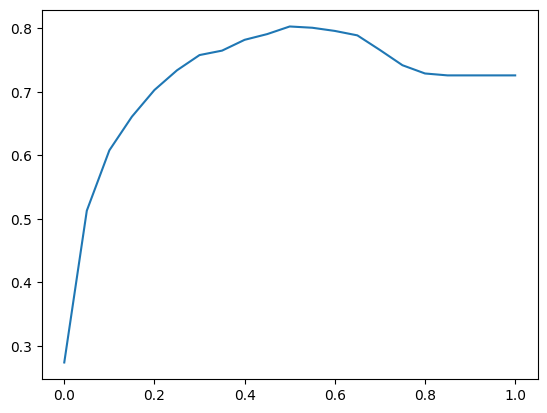

In [11]:
plt.plot(thresholds, scores)

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
accuracy_score(y_val, churn_decision)

0.7260468417317246

In [13]:
scores = []
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    scores.append(score)
    print('%.2f %.3f' % (t, score))

0.00 0.274
0.05 0.513
0.10 0.608
0.15 0.661
0.20 0.703
0.25 0.734
0.30 0.758
0.35 0.765
0.40 0.782
0.45 0.791
0.50 0.803
0.55 0.801
0.60 0.796
0.65 0.789
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [14]:
from collections import Counter
Counter(y_pred >= 0.5)

Counter({np.False_: 1094, np.True_: 315})

In [16]:
Counter(y_val)

Counter({np.int64(0): 1023, np.int64(1): 386})

In [17]:
y_val.mean()

np.float64(0.2739531582682754)

In [18]:
1 - y_val.mean()

np.float64(0.7260468417317246)

## 4.3 Confusion table

* Different types of errors and correct decisions
* Arranging them in a table

In [15]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [16]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [17]:
# true positive
tp = (predict_positive & actual_positive).sum()

In [18]:
# true negative
tn = (predict_negative & actual_negative).sum()

In [19]:
# false positive
fp = (predict_positive & actual_negative).sum()

In [20]:
# false negative
fn = (predict_negative & actual_positive).sum()

In [21]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[920, 103],
       [174, 212]])

In [22]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## Precision and Recall

Precision is fraction of positive predictions that are correct

Recall is fraction of correctly identified positive examples

Precision = 67% (33% were identified as churned but were not actually churned)

Recall = 55% (45% were identified as not churned but were actually churned)

Accuracy = 80% (misleading metric in this case)

In [23]:
# accuracy through confusion matrix
acc = (tp + tn) / (tp + tn + fp + fn)
acc

np.float64(0.8034066713981547)

In [24]:
# calculating precision
precision = (tp) / (tp + fp)
precision

np.float64(0.6730158730158731)

In [25]:
# calculating recall
recall = (tp) / (tp + fn)
recall

np.float64(0.5492227979274611)

## ROC curves

TPR (True Positive Rate) and FPR (False Positive Rate)

In [26]:
tpr = tp / (tp + fn)
tpr

np.float64(0.5492227979274611)

In [27]:
fpr = fp / (fp + tn)
fpr

np.float64(0.10068426197458455)

In [28]:
# calculate tpr / fpr for different threshold values and plot them

scores = []
thresholds = np.linspace(0, 1, 101)
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [29]:
df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])
df_scores.head()

,threshold,tp,fp,fn,tn
0,0.00,386,1023,0,0
1,0.01,385,894,1,129
2,0.02,383,804,3,219
3,0.03,382,749,4,274
4,0.04,382,709,4,314


In [30]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [31]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,533,20,490,0.948187,0.521017
20,0.2,339,372,47,651,0.878238,0.363636
30,0.3,292,247,94,776,0.756477,0.241447
40,0.4,254,175,132,848,0.658031,0.171065
50,0.5,212,103,174,920,0.549223,0.100684
60,0.6,151,53,235,970,0.391192,0.051808
70,0.7,69,13,317,1010,0.178756,0.012708
80,0.8,4,0,382,1023,0.010363,0.000000
90,0.9,0,0,386,1023,0.000000,0.000000


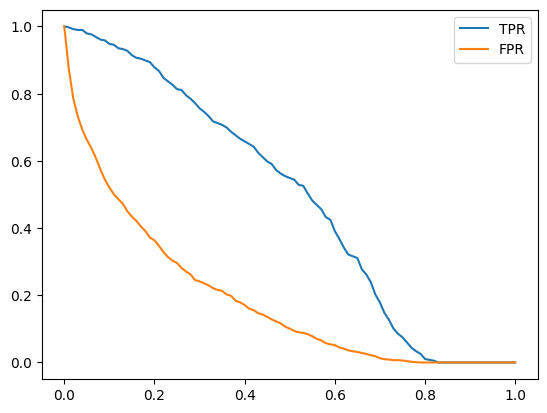

In [23]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

#### Random model

In [31]:
# Random predictions (probabilities from 0 to 1)
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand[:5]

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, 3.02332573e-01,
       1.46755891e-01])

In [32]:
# checking accuracy of random model
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [33]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        scores.append((t, tp, fp, fn, tn))
    df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    return df_scores

In [34]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


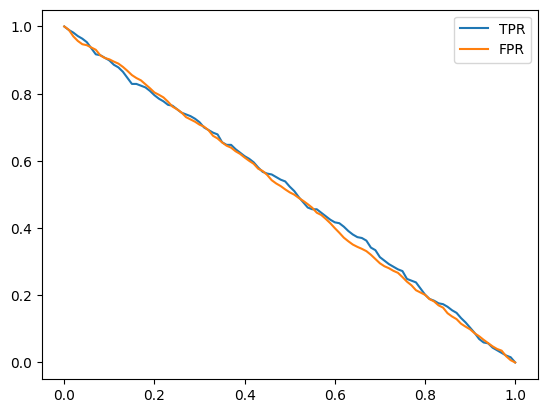

In [28]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

#### Ideal model

In [35]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [36]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1], shape=(1409,))

In [37]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [38]:
(1 - y_val.mean()).round(3)

np.float64(0.726)

In [39]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

np.float64(1.0)

In [38]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

In [39]:
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


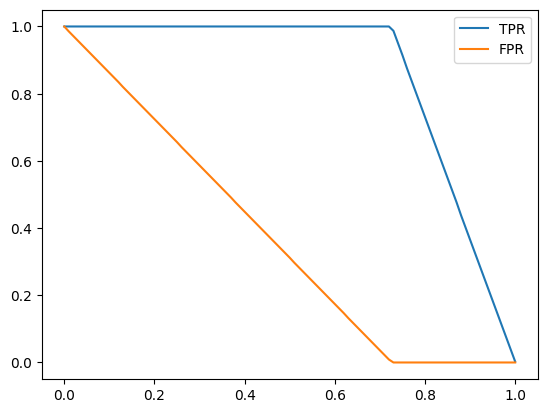

In [48]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

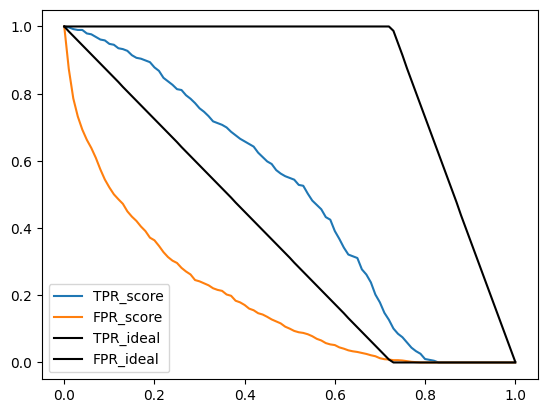

In [49]:
# plotting all models at once: score, random, ideal

plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR_score')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR_score')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR_rand')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR_rand')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR_ideal', color='black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR_ideal', color='black')

plt.legend()

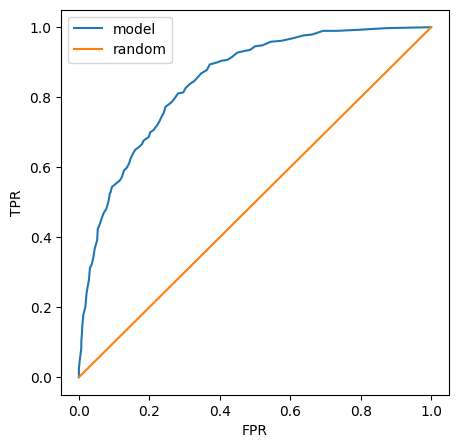

In [82]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label = 'model')

#plt.plot(df_rand.fpr, df_rand.tpr, label = 'rand')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label = 'ideal')
plt.plot([0, 1], [0, 1], label = 'random')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [40]:
# use sklearn to get fpr, tpr
from sklearn.metrics import roc_curve

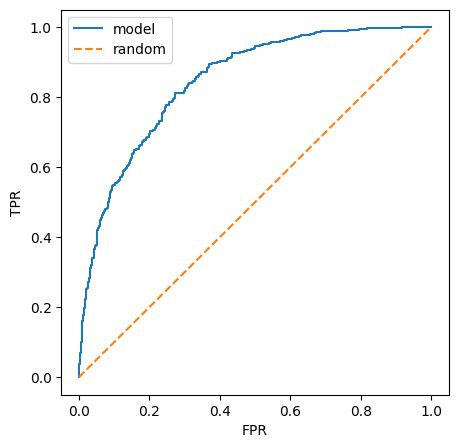

In [41]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label = 'model')
plt.plot([0, 1], [0, 1], label = 'random', linestyle="--")

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

#### ROC AUC

In [42]:
from sklearn.metrics import auc

In [43]:
auc(fpr, tpr)

0.8463120254863528

In [37]:
auc(df_scores.fpr, df_scores.tpr)

0.8459194991870908

In [48]:
auc(df_rand.fpr, df_rand.tpr)

0.5060233793728696

In [49]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [44]:
from sklearn.metrics import roc_auc_score

In [45]:
roc_auc_score(y_val, y_pred)

0.8463120254863528

In [46]:
# check manually roc auc logic - manual interpretation of roc auc 
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [47]:
import random

In [48]:
pos_ind = random.randint(0, len(pos) -1)
neg_ind = random.randint(0, len(neg) -1)
print(f"pos_ind = {pos_ind}")
print(f"neg_ind = {neg_ind}")

pos_ind = 245
neg_ind = 479


In [49]:
pos[pos_ind] > neg[neg_ind]

np.True_

In [50]:
n = 100000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) -1)
    neg_ind = random.randint(0, len(neg) -1)

    if pos[pos_ind] > neg[neg_ind]:
        success += 1

success / n

0.84726

In [57]:
# doing same with numpy

n = 1000000
np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)
(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.846386)

### Cross-Validation

In [76]:
# implement train function

def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(max_iter=10000, C=C)
    model.fit(X_train, y_train)
    return dv, model

In [64]:
dv, model = train(df_train, y_train, C=10)

In [77]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient="records")
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [54]:
y_pred = predict(df_val, dv, model)

In [78]:
from sklearn.model_selection import KFold

In [79]:
kfold = KFold(n_splits = 10, shuffle = True, random_state = 1)

In [88]:
from tqdm.auto import tqdm

n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]):
    scores = []

    kfold = KFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=1
    )

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val   = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val   = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))


  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.008
C=0.1 0.842 +- 0.007
C=0.5 0.842 +- 0.007
C=1.0 0.842 +- 0.007
C=5.0 0.842 +- 0.007
C=10.0 0.842 +- 0.007


In [75]:
scores

[0.8496891051635577,
 0.8423576732673268,
 0.8582960982010862,
 0.8332236029956382,
 0.8248604218362282,
 0.8410922410922411,
 0.8431129925105829,
 0.8252609108159393,
 0.8458425967096488,
 0.8609794628751974]

In [59]:
print("%.3f +- %.3f" % (np.mean(scores), np.std(scores)))

0.842 +- 0.012


In [92]:
# final step - train our final model on full train dataset

y_full_train = df_full_train.churn.values
dv, model = train(df_full_train, y_full_train, C=1.0)
y_pred = predict(df_test, dv, model)
auc = roc_auc_score(y_test, y_pred)
auc

0.8584032088573997

## Summary

* Metric - a single number that describes the performance of a model
* Accuracy - fraction of correct answers; sometimes misleading 
* Precision and recall are less misleading when we have class inbalance
* ROC Curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
* K-Fold CV - more reliable estimate for performance (mean + std)